In [1]:
from torchcore.util import Config
from torchcore.dnn.networks.detectors.build import build_detector
cfg = 'configs/fcos/fcos_resnet50_fpn_fashion_pedia_aug_hard_grammar.py'
config = Config.fromfile(cfg)
model=build_detector(config.model)


init from pretrained model


In [2]:
from train import load_checkpoint
model_path = '/home/dsv/qida0163/Vision/data/fcos/fcos_resnet50_fpn_fashion_pedia_aug_20211114_aug/checkpoints/checkpoint_20211114_aug_step_180000.pth'
load_checkpoint(model, model_path, 'cpu')

Chekpoint has been loaded from /home/dsv/qida0163/Vision/data/fcos/fcos_resnet50_fpn_fashion_pedia_aug_20211114_aug/checkpoints/checkpoint_20211114_aug_step_180000.pth


In [3]:
from torchcore.data.datasets.build import build_dataloader
from torchcore.util.config import Config

config.dataloader_val.batch_size=1
val_dataset_loader = build_dataloader(config.dataloader_val,distributed=False)

In [4]:
json_path = os.path.expanduser('~/data/datasets/Fashionpedia/annotations/instances_attributes_val2020.json')

names = val_dataset_loader.dataset.get_coco_style_names(json_path, with_cat_id=True)

loading annotations into memory...
Done (t=0.24s)
creating index...
index created!


In [5]:
for i in range(19):
    names[46+i] = 'del_'+names[27+i]

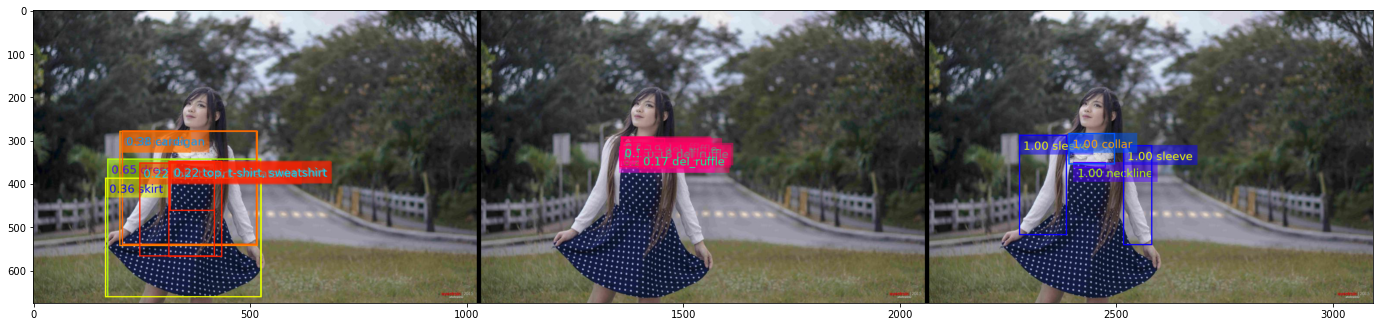

In [20]:
%matplotlib inline
from torchcore.tools.visulize_tools import draw_plain_boxes, draw_single_image,cat_images_with_same_size
from torchcore.tools.visulize_tools import visulize_heatmaps_with_image, visulize_colored_heatmaps_with_image
from torchcore.tools.color_gen import random_colors
from torchcore.data.util import set_device
import matplotlib.pyplot as plt
import os
from pycocotools.coco import COCO
import numpy as np

dataset= val_dataset_loader.dataset
score_thresh = 0.2
colors = random_colors(46)
colors = colors + colors[27:]
model.eval()
device = 'cuda'
model.to(device)

for i, (inputs, targets) in enumerate(val_dataset_loader):
    if i < 100:
        continue
    inputs = set_device(inputs, device)
    targets = set_device(targets, device)
    results = model(inputs, targets)
    input, target = dataset[i]
    im = input['data']
    im1 = im.copy()
    gt_im = im.copy()
    boxes = results['boxes'][0].detach().cpu().numpy()
    labels= results['labels'][0].detach().cpu().numpy()-1
    scores = results['scores'][0].detach().cpu().numpy()

    keep1 = labels>45
    if keep1.sum()==0:
        continue

    #keep = np.logical_or(np.logical_and(labels<13,(scores > score_thresh)), (labels>45))
    keep = np.logical_and(labels<13,(scores > score_thresh)) 
    boxes0 = boxes[keep]
    labels0 = labels[keep]
    scores0 = scores[keep]
    draw_plain_boxes(im, boxes0)
    draw_single_image(im, boxes0, scores0, labels0, colors, class_names=names)

    boxes1 = boxes[keep1]
    labels1 = labels[keep1]
    scores1 = scores[keep1]
    draw_plain_boxes(im1, boxes1)
    draw_single_image(im1, boxes1, scores1, labels1, colors, class_names=names)

    gt_boxes = target['boxes']
    gt_labels = target['labels']-1
    keep = gt_labels > 26
    gt_boxes = gt_boxes[keep]
    gt_labels = gt_labels[keep]
    draw_plain_boxes(gt_im, gt_boxes)
    draw_single_image(gt_im, gt_boxes, None, gt_labels, colors, class_names=names)

    im_out = cat_images_with_same_size([im, im1, gt_im],3)
    plt.figure(figsize=(24,8))
    plt.imshow(im_out)

    if i>101:
        break

In [ ]:
%matplotlib inline
from torchcore.tools.visulize_tools import draw_plain_boxes, draw_single_image
from torchcore.tools.visulize_tools import visulize_heatmaps_with_image, visulize_colored_heatmaps_with_image
from torchcore.tools.color_gen import random_colors
import matplotlib.pyplot as plt
import os
from pycocotools.coco import COCO
import numpy as np

dataset= val_dataset_loader.dataset
score_thresh = 0.2
colors = random_colors(46+19)
model.eval()

for i, (inputs, targets) in enumerate(val_dataset_loader):
    if i < 100:
        continue
    results = model(inputs, targets)
    input, target = dataset[i]
    im = input['data']
    boxes = results['boxes'][0].detach().numpy()
    labels= results['labels'][0].detach().numpy()-1
    scores = results['scores'][0].detach().numpy()

    keep = np.logical_or(np.logical_and(labels<13,(scores > score_thresh)), (labels>45))
    #keep = labels>45
    boxes = boxes[keep]
    labels = labels[keep]
    scores = scores[keep]
    draw_plain_boxes(im, boxes)
    draw_single_image(im, boxes, scores, labels, colors, class_names=names)
    #heatmap = class_hp[fpn_layer][0].detach().numpy()
    #heatmap = centerness_hp[fpn_layer][0].detach().numpy()
    #mixim=visulize_colored_heatmaps_with_image(heatmap, im)
    plt.figure(figsize=(8,8))
    plt.imshow(im)

    if i>110:
        break